## Set up

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import seaborn as sns
import os
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import warnings
import lightning.pytorch as pl
import torch
import pickle

from datetime import datetime, timedelta
from tqdm import tqdm
from sklearn.tree import DecisionTreeRegressor, plot_tree

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

np.random.seed(42)

In [3]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

## Import the data

In [4]:
online_retail_df = pd.read_json('../../dataset/online_retail_data/online_retail.json')
online_retail_df

,Description,Date,UnitsSold,RevenuePounds,AveragePricePerUnitPounds
0,12 pencils small tube red spotty,2009-12-01,45,29.90,0.66
1,12 pencils small tube red spotty,2009-12-02,87,61.75,0.71
2,12 pencils small tube red spotty,2009-12-03,34,23.40,0.69
3,12 pencils small tube red spotty,2009-12-04,84,55.25,0.66
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.00
...,...,...,...,...,...
73299,heart of wicker large,2010-12-05,94,261.30,2.78
73300,heart of wicker large,2010-12-06,34,118.06,3.47
73301,heart of wicker large,2010-12-07,462,1451.10,3.14
73302,heart of wicker large,2010-12-08,35,106.21,3.03


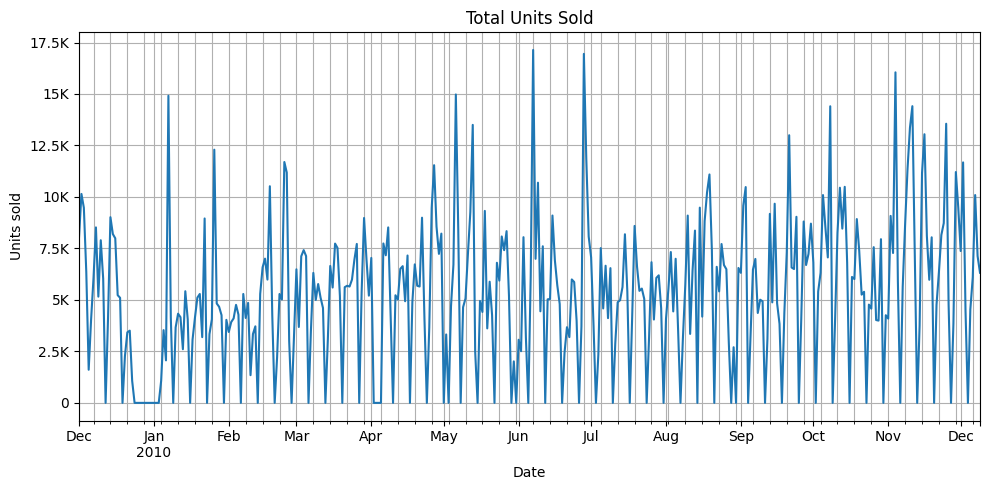

In [5]:
fig, ax = plt.subplots(figsize=(10,5))

online_retail_df.groupby('Date')['UnitsSold'].sum().plot(ax=ax)

ax.set_title('Total Units Sold')
ax.set_xlabel('Date')
ax.set_ylabel('Units sold')
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

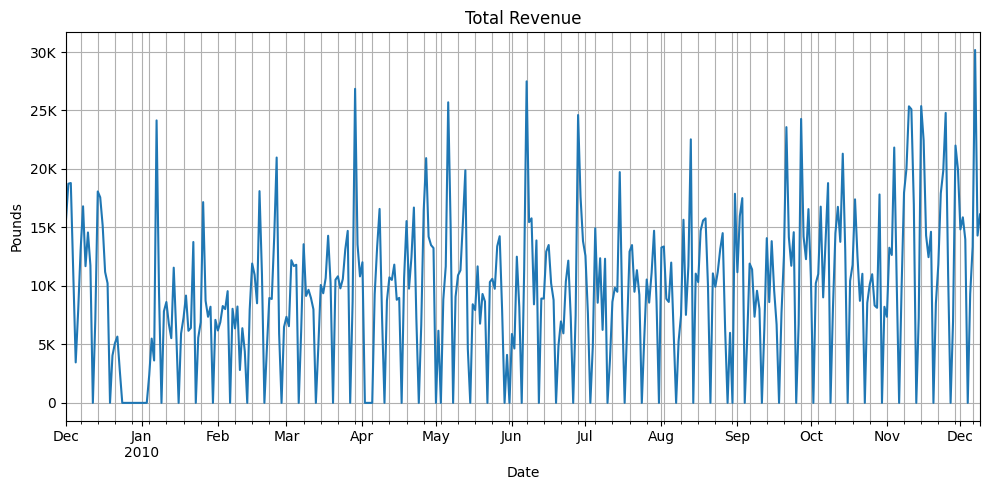

In [6]:
fig, ax = plt.subplots(figsize=(10,5))

online_retail_df.groupby('Date')['RevenuePounds'].sum().plot(ax=ax)

ax.set_title('Total Revenue')
ax.set_xlabel('Date')
ax.set_ylabel('Pounds')
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

In [7]:
sample_products = online_retail_df.groupby('Description')['UnitsSold'].sum().sort_values(ascending=False).index.values

In [8]:
def visualize_product_series(time_series: pd.Series, product_name: str, series_name: str = "Value"):
    """
    Visualizes a time series for a given product, including time plot, weekly and monthly
    box plots, histogram, log histogram, ACF, PACF plots, and per-weekday histograms.

    Args:
        time_series: A pandas Series with dates as the index and the values of the time series
                     (e.g., units sold or revenue).
        product_name: The name of the product (for plot titles).
        series_name: The name of the series being visualized (e.g., "Units Sold", "Revenue in Pounds")
                     for y-axis labels and specific plot titles.
    """
    plt.figure(figsize=(20, 20)) # Increased figure size to accommodate the new subplot
    plt.suptitle(f"Analysis of {series_name} for {product_name}", fontsize=16)

    # 1. Plot the time series
    plt.subplot(5, 2, 1)
    time_series.plot(title=f'Daily {series_name}')
    plt.xlabel('Date')
    plt.ylabel(series_name)
    plt.grid(True)

    # 2. Plot a box plot by day of the week
    plt.subplot(5, 2, 2)
    df_temp = time_series.copy().to_frame(name=series_name)
    df_temp['Day of Week'] = df_temp.index.day_name()
    sns.boxplot(x='Day of Week', y=series_name, data=df_temp, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.title(f'{series_name} by Day of the Week')
    plt.xlabel('Day of the Week')
    plt.ylabel(series_name)

    # 3. Plot a box plot by Month
    plt.subplot(5, 2, 3)
    df_temp['Month'] = df_temp.index.month_name()
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    sns.boxplot(x='Month', y=series_name, data=df_temp, order=month_order)
    plt.title(f'{series_name} by Month')
    plt.xlabel('Month')
    plt.ylabel(series_name)
    plt.xticks(rotation=45, ha='right')

    # 4. Plot a histogram of the value of the time series
    plt.subplot(5, 2, 4)
    sns.histplot(time_series, kde=True)
    plt.title(f'Histogram of Daily {series_name}')
    plt.xlabel(series_name)
    plt.ylabel('Frequency')

    # 5. Plot a log histogram of the time series (excluding zero values)
    plt.subplot(5, 2, 5)
    non_zero_values = time_series[time_series > 0]
    if not non_zero_values.empty:
        sns.histplot(np.log(non_zero_values), kde=True)
        plt.title(f'Log Histogram of Daily {series_name} (Non-Zero)')
        plt.xlabel(f'log({series_name})')
        plt.ylabel('Frequency')
    else:
        plt.title(f'No Non-Zero Values to Plot Log Histogram for {series_name}')

    # 6. Plot per-weekday histograms (excluding zeros, same axes, different colors, alpha=0.5, legend)
    plt.subplot(5, 2, 6)
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    colors = plt.cm.viridis(np.linspace(0, 1, len(days))) # Generate a colormap
    for day, color in zip(days, colors):
        weekday_data = df_temp[df_temp['Day of Week'] == day][series_name]
        non_zero_weekday_data = weekday_data[weekday_data > 0]
        if not non_zero_weekday_data.empty:
            sns.histplot(np.log(non_zero_weekday_data), color=color, alpha=0.5, label=day, kde=False) # kde=False for clarity on overlapping
    plt.title(f'Weekday Distribution of {series_name} (Non-Zero)')
    plt.xlabel(series_name)
    plt.ylabel('Frequency')
    plt.legend()

    # 7. Plot the Autocorrelation Function (ACF)
    plt.subplot(5, 2, 9) # Adjusted subplot index
    plot_acf(time_series, lags=30, ax=plt.gca())
    plt.title(f'Autocorrelation Function (ACF) - {series_name}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')

    # 8. Plot the Partial Autocorrelation Function (PACF)
    plt.subplot(5, 2, 10) # Adjusted subplot index
    plot_pacf(time_series, lags=30, method='ywmle', ax=plt.gca())
    plt.title(f'Partial Autocorrelation Function (PACF) - {series_name}')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [9]:
i = 0
visualize_product_series(pivoted_df['UnitsSold'][sample_products[i]], sample_products[i], 'UnitsSold')
visualize_product_series(pivoted_df['RevenuePounds'][sample_products[i]], sample_products[i], 'Revenue')

NameError: name 'pivoted_df' is not defined

In [ ]:
i = 1
visualize_product_series(pivoted_df['UnitsSold'][sample_products[i]], sample_products[i], 'UnitsSold')
visualize_product_series(pivoted_df['RevenuePounds'][sample_products[i]], sample_products[i], 'Revenue')

In [ ]:
i = 2
visualize_product_series(pivoted_df['UnitsSold'][sample_products[i]], sample_products[i], 'UnitsSold')
visualize_product_series(pivoted_df['RevenuePounds'][sample_products[i]], sample_products[i], 'Revenue')

In [ ]:
i = 3
visualize_product_series(pivoted_df['UnitsSold'][sample_products[i]], sample_products[i], 'UnitsSold')
visualize_product_series(pivoted_df['RevenuePounds'][sample_products[i]], sample_products[i], 'Revenue')

## Prepare the data

In [11]:
feature_dataset_df = online_retail_df[['Description', 'Date', 'UnitsSold', 'AveragePricePerUnitPounds', 'RevenuePounds']].copy()
feature_dataset_df['DayOfWeek_Str'] = feature_dataset_df['Date'].dt.day_name()

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

feature_dataset_df['DayOfWeek_CatOrdered'] = pd.Categorical(
    feature_dataset_df['DayOfWeek_Str'], categories=ordered_days, ordered=True
)

feature_dataset_df['DayOfWeek_Numerical'] = feature_dataset_df['DayOfWeek_CatOrdered'].cat.codes

day_of_week_dummies_ordered = pd.get_dummies(
    feature_dataset_df['DayOfWeek_CatOrdered'], dtype=int
)

feature_dataset_df = pd.concat([feature_dataset_df, day_of_week_dummies_ordered], axis=1)
feature_dataset_df = feature_dataset_df.drop(columns=[
    'DayOfWeek_Str',
    'DayOfWeek_CatOrdered',
])

feature_dataset_df['DayOfMonth'] = feature_dataset_df['Date'].dt.day

feature_dataset_df['DayBefore'] = feature_dataset_df.groupby('Description')['UnitsSold'].shift(1)
feature_dataset_df['TwoDaysBefore'] = feature_dataset_df.groupby('Description')['UnitsSold'].shift(2)
feature_dataset_df['WeekBefore'] = feature_dataset_df.groupby('Description')['UnitsSold'].shift(7)
feature_dataset_df['MonthBefore'] = feature_dataset_df.groupby('Description')['UnitsSold'].shift(30)

feature_dataset_df = feature_dataset_df.fillna(0)

feature_dataset_df = feature_dataset_df.sort_values(by=['Description', 'Date'])

feature_dataset_df

,Description,Date,UnitsSold,AveragePricePerUnitPounds,RevenuePounds,DayOfWeek_Numerical,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,DayOfMonth,DayBefore,TwoDaysBefore,WeekBefore,MonthBefore
0,12 pencils small tube red spotty,2009-12-01,45,0.66,29.90,1,0,1,0,0,0,0,0,1,0.0,0.0,0.0,0.0
1,12 pencils small tube red spotty,2009-12-02,87,0.71,61.75,2,0,0,1,0,0,0,0,2,45.0,0.0,0.0,0.0
2,12 pencils small tube red spotty,2009-12-03,34,0.69,23.40,3,0,0,0,1,0,0,0,3,87.0,45.0,0.0,0.0
3,12 pencils small tube red spotty,2009-12-04,84,0.66,55.25,4,0,0,0,0,1,0,0,4,34.0,87.0,0.0,0.0
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.00,5,0,0,0,0,0,1,0,5,84.0,34.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53477,zinc metal heart decoration,2010-12-05,34,1.25,42.50,6,0,0,0,0,0,0,1,5,0.0,6.0,54.0,1.0
53478,zinc metal heart decoration,2010-12-06,33,1.52,50.07,0,1,0,0,0,0,0,0,6,34.0,0.0,82.0,0.0
53479,zinc metal heart decoration,2010-12-07,51,1.27,65.01,1,0,1,0,0,0,0,0,7,33.0,34.0,36.0,33.0
53480,zinc metal heart decoration,2010-12-08,20,1.31,26.26,2,0,0,1,0,0,0,0,8,51.0,33.0,27.0,81.0


In [12]:
last_date = feature_dataset_df['Date'].max() - timedelta(days=30)
train_df = feature_dataset_df[lambda x: x['Date'] <= last_date]
val_df = feature_dataset_df[lambda x: x['Date'] > last_date]

## Decision tree

In [13]:
def train_trees(train_df: pd.DataFrame, features: list[str], target: str, criterion: str = 'squared_error'):
    products = train_df['Description'].unique()
    tree_models = dict()
    for product in products:
        product_train_df = train_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
        X_train, y_train = product_train_df[features], product_train_df[target]
        tree_models[product] = (
            DecisionTreeRegressor(random_state=42, criterion=criterion)
            .fit(X_train, y_train)
        )
    return tree_models

In [14]:
features = [
    'AveragePricePerUnitPounds',
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    'DayOfMonth',
    'DayBefore', 'WeekBefore', 'MonthBefore',
]
target = 'UnitsSold'

tree_models = train_trees(train_df, features, target)

In [56]:
def get_autoregressive_predictions(
    tree_model: DecisionTreeRegressor,
    prev_values: pd.Series,
    known_future_prices_per_unit: pd.Series,
):
    """
    Performs an autogressive forecast using the tree.

    Args:
        tree_model: A trained DecisionTreeRegressor.
        prev_values: A Pandas series containing all known previous unit sales. The index
            should be the date.
        known_future_prices_per_unit: A Pandas series with the known price of the good
            during the dates to forecast. Should have dates as index.
    Returns:
        A series representing the predictions for the next number of days.
    """
    values = prev_values.sort_index()
    known_future_prices_per_unit = known_future_prices_per_unit.sort_index()
    for date in known_future_prices_per_unit.index:
        price = known_future_prices_per_unit.loc[date]
        
        is_monday = date.dayofweek == 0
        is_tuesday = date.dayofweek == 1
        is_wednesday = date.dayofweek == 2
        is_thursday = date.dayofweek == 3
        is_friday = date.dayofweek == 4
        is_saturday = date.dayofweek == 5
        is_sunday = date.dayofweek == 6

        day_of_month = date.day
        
        prev_day = values.loc[date - timedelta(days=1)]
        prev_week = values.loc[date - timedelta(days=7)]
        prev_month = values.loc[date - timedelta(days=30)]
        
        X = np.array([[
            price,
            is_monday,
            is_tuesday,
            is_wednesday,
            is_thursday,
            is_friday,
            is_saturday,
            is_sunday,
            day_of_month,
            prev_day,
            prev_week,
            prev_month
        ]])
        pred = round(tree_model.predict(X)[0])
        values[date] = pred
    return values.loc[known_future_prices_per_unit.index]
        
def get_predictions_for_product(tree_model, all_values, known_future_prices_per_unit, forecast_len = 7):
    all_values = all_values.sort_index()
    known_future_prices_per_unit = known_future_prices_per_unit.sort_index()
    predictions_df = pd.DataFrame(columns=range(1, forecast_len + 1), index=product_val_df.index)
    for date in known_future_prices_per_unit.index:
        end_date = date+timedelta(days=forecast_len)
        preds = get_autoregressive_predictions(
            tree_model,
            all_values.loc[:date],
            known_future_prices_per_unit.loc[date:end_date],
        )
        np.fill_diagonal(predictions_df.loc[date:end_date,:len(preds)].values, preds)
    results_df = predictions_df.copy()
    results_df['observed'] = all_values.loc[known_future_prices_per_unit.index]
    return results_df.reset_index()

def get_predictions(tree_models, train_df, val_df, forecast_len = 7):
    products = val_df['Description'].unique()
    dfs = list()
    for product in tqdm(products):
        if product not in tree_models:
            print(f'Warning: Found no model for "{product}"')
            continue
        tree_model = tree_models[product]
        product_train_df = train_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
        product_val_df = val_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
        all_values = pd.concat([product_train_df['UnitsSold'], product_val_df['UnitsSold']], axis=0).sort_index()
        known_future_prices_per_unit = product_val_df['AveragePricePerUnitPounds'].sort_index()

        results_df = get_predictions_for_product(tree_models[product], all_values, known_future_prices_per_unit)
        results_df.insert(0, 'Product', product)
        dfs.append(results_df.copy())
    return pd.concat(dfs, axis=0, ignore_index=True).reset_index(drop=True)

In [57]:
results_df = get_predictions(tree_models, train_df, val_df)
results_df

100%|█████████████████████████████████████████| 196/196 [00:13<00:00, 14.18it/s]


,Product,Date,1,2,3,4,5,6,7,observed
0,12 pencils small tube red spotty,2010-11-10,84,NaN,NaN,NaN,NaN,NaN,NaN,182
1,12 pencils small tube red spotty,2010-11-11,140,140,NaN,NaN,NaN,NaN,NaN,108
2,12 pencils small tube red spotty,2010-11-12,48,48,48,NaN,NaN,NaN,NaN,112
3,12 pencils small tube red spotty,2010-11-13,0,0,0,0,NaN,NaN,NaN,0
4,12 pencils small tube red spotty,2010-11-14,169,169,169,169,169,NaN,NaN,41
...,...,...,...,...,...,...,...,...,...,...
5875,zinc metal heart decoration,2010-12-05,24,24,24,24,24,24,24,34
5876,zinc metal heart decoration,2010-12-06,25,25,25,25,25,25,25,33
5877,zinc metal heart decoration,2010-12-07,63,63,63,63,63,63,63,51
5878,zinc metal heart decoration,2010-12-08,53,53,53,53,53,53,53,20


In [95]:
def calculated_ape_for_row(row, forecast_len = 7):
    numerator = np.abs(row.loc[1:forecast_len] - row.loc['observed'])
    denominator = row.loc['observed']
    ape = numerator / (denominator + 1e-16)
    return ape

ape_df = results_df.set_index(['Date', 'Product']).apply(calculated_ape_for_row, axis=1).reset_index()
ape_df

,Date,Product,1,2,3,4,5,6,7
0,2010-11-10,12 pencils small tube red spotty,0.538462,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-11-11,12 pencils small tube red spotty,0.296296,0.296296,NaN,NaN,NaN,NaN,NaN
2,2010-11-12,12 pencils small tube red spotty,0.571429,0.571429,0.571429,NaN,NaN,NaN,NaN
3,2010-11-13,12 pencils small tube red spotty,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
4,2010-11-14,12 pencils small tube red spotty,3.121951,3.121951,3.121951,3.121951,3.121951,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5875,2010-12-05,zinc metal heart decoration,0.294118,0.294118,0.294118,0.294118,0.294118,0.294118,0.294118
5876,2010-12-06,zinc metal heart decoration,0.242424,0.242424,0.242424,0.242424,0.242424,0.242424,0.242424
5877,2010-12-07,zinc metal heart decoration,0.235294,0.235294,0.235294,0.235294,0.235294,0.235294,0.235294
5878,2010-12-08,zinc metal heart decoration,1.650000,1.650000,1.650000,1.650000,1.650000,1.650000,1.650000


In [103]:
mape_df = ape_df.drop(columns=['Date']).groupby('Product').mean()
mape_df

,1,2,3,4,5,6,7
Product,,,,,,,
12 pencils small tube red spotty,1.645067,0.724106,0.659025,0.699565,0.682065,0.584469,0.580313
12 pencils tall tube posy,2.353138,2.353973,2.268655,2.303297,2.391885,2.450637,2.535203
12 pencils tall tube woodland,1.370125,1.129315,1.167415,1.178907,1.224249,1.249771,1.285178
3 stripey mice feltcraft,2.135572,2.186261,2.245111,2.306041,2.394735,2.490524,2.323463
6 ribbons rustic charm,0.709008,0.763897,0.763868,0.769099,0.798679,0.715626,0.708293
...,...,...,...,...,...,...,...
wooden picture frame white finish,1.120871,0.953565,0.960528,0.977584,1.015184,1.040406,1.055979
wooden school colouring set,0.957122,1.107534,1.035184,1.038545,1.078489,1.094260,1.111209
woodland charlotte bag,0.829529,0.881581,0.891930,0.898870,0.933442,0.958606,0.985951


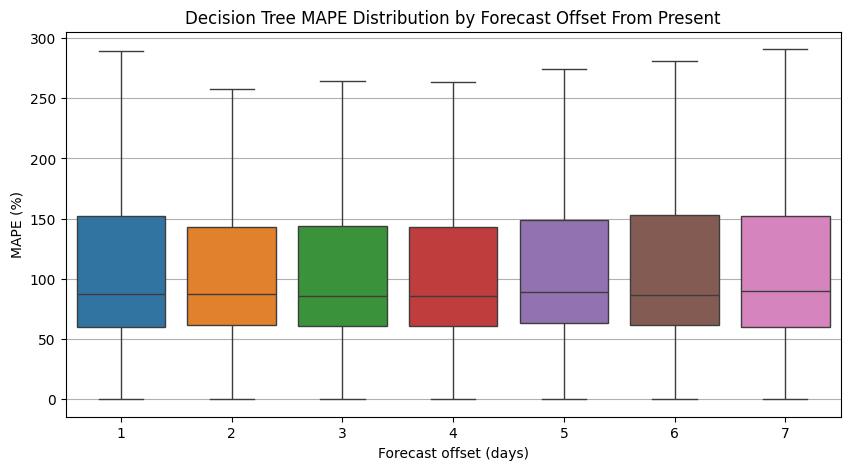

In [124]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=mape_df * 100, showfliers=False, ax=ax)

ax.set_title('Decision Tree MAPE Distribution by Forecast Offset From Present')
ax.set_xlabel('Forecast offset (days)')
ax.set_ylabel('MAPE (%)')
ax.yaxis.grid(True)

In [136]:
mape_df[1].sort_values().head(20)

Product
lunch bag red spotty                  0.000000
toy tidy pink retrospot               0.000000
charlotte bag pinkwhite spots         0.000000
door mat red spot                     0.000000
blue spotty cup                       0.000000
lunchbag pink retrospot               0.000000
red spotty bowl                       0.000000
jumbo bag pink with white spots       0.060000
baking set 9 piece retrospot          0.150000
ladies gentlemen metal sign           0.269355
retro spot storage jar                0.274359
pink 3 piece mini dots cutlery set    0.288889
grand chocolatecandle                 0.376253
white hanging heart tlight holder     0.392986
set of 72 pink heart paper doilies    0.404715
hot water bottle tea and sympathy     0.406667
wood black board ant white finish     0.408060
red spotty round cake tins            0.408391
assorted colour bird ornament         0.414520
feltcraft cushion owl                 0.416082
Name: 1, dtype: float64

<Axes: >

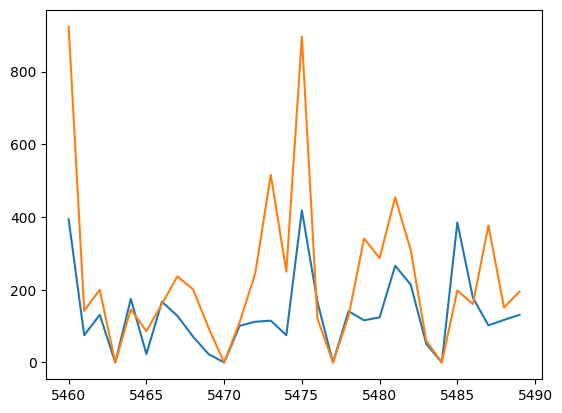

In [141]:
results_df[lambda x: x['Product'] == 'white hanging heart tlight holder'][1].plot()
results_df[lambda x: x['Product'] == 'white hanging heart tlight holder']['observed'].plot()

In [127]:
ape_by_day_of_week = ape_df[['Date', 1]].copy()
ape_by_day_of_week['DayOfWeek'] = ape_by_day_of_week['Date'].dt.day_name()
ape_by_day_of_week.pivot(index='')

,Date,1,DayOfWeek
0,2010-11-10,0.538462,Wednesday
1,2010-11-11,0.296296,Thursday
2,2010-11-12,0.571429,Friday
3,2010-11-13,0.000000,Saturday
4,2010-11-14,3.121951,Sunday
...,...,...,...
5875,2010-12-05,0.294118,Sunday
5876,2010-12-06,0.242424,Monday
5877,2010-12-07,0.235294,Tuesday
5878,2010-12-08,1.650000,Wednesday
